In [1]:
import pandas as pd
import numpy as np

In [2]:
from dateutil import parser
from datetime import datetime
import sys, os
import re
import optuna
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RepeatedKFold, KFold, ShuffleSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
optuna.logging.set_verbosity(optuna.logging.WARNING)
from Stacking_model import BoostedHybrid

In [3]:
#9. read resources 
data = pd.read_csv('data.csv',
                  parse_dates=['date'],
                  infer_datetime_format=True,
                  index_col = 0)

In [4]:
#del outliers
data = data.loc[data.outliers != -1]

In [5]:
#it's not a category feature
data.onpromotion = data.onpromotion.astype('float64')

In [6]:
#let's create skus
data['sku'] = data.store_nbr.astype('str') + '-' + data.family

In [7]:
data['cumsum'] = data.groupby('sku')['sales_1'].expanding(1).sum().reset_index().set_index('date').sort_values(['date', 'sku'])['sales_1']

In [8]:
#for Kaggle
final = data.loc[data.index.max()]
#for comparing approaches
holdout = data.loc[(data.index.max()-pd.Timedelta('30d')) :\
                       (data.index.max()-pd.Timedelta('1d'))]

#### `Exclude skus with zero and nearly zero consumption`

In [9]:
#let's find skus without any consumption and exclude them from the dataset
dg = data.groupby('sku')['sales_1'].sum()
sku_0 = dg.loc[dg == 0].index

In [10]:
len(sku_0)

70

In [11]:
dg2 = data.groupby(['sku', 'year'])['sales_1'].sum().reset_index()

In [12]:
dg2['cs'] = dg2.groupby(['sku'])['sales_1'].expanding(1).sum().values

In [13]:
#sksu with zero consumption in 2017
sku_1 = dg2.loc[(dg2.year == 2017) &\
            (dg2.sales_1 == 0), 'sku'].unique()

In [14]:
#skus with zero consumption in 2017 and nonzero in previous periods
strange_skus = np.setdiff1d(sku_1, sku_0)

<AxesSubplot: xlabel='date'>

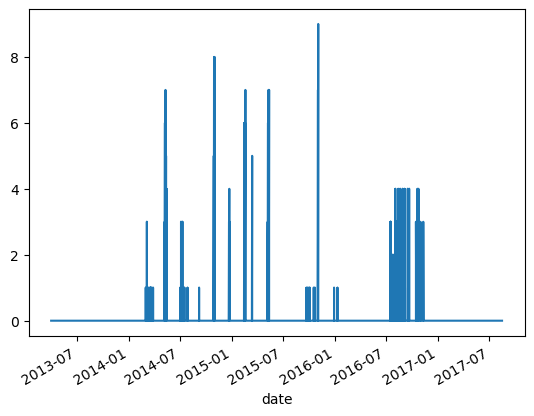

In [15]:
data.loc[data.sku.isin(strange_skus), 'sales_1'].plot()

##### `It's better to delete these skus also`

In [16]:
data = data.loc[~data.sku.isin(sku_1)]

In [17]:
#sksu with zero consumption before 2017 and nonzero in 2017
sku_2 = dg2.loc[(dg2.year == 2017) &\
            (dg2.sales_1 >0) &\
                (dg2.cs == dg2.sales_1), 'sku'].unique()

In [18]:
len(sku_2)

32

##### `It looks like 52 store opened in 2017`

<AxesSubplot: xlabel='date'>

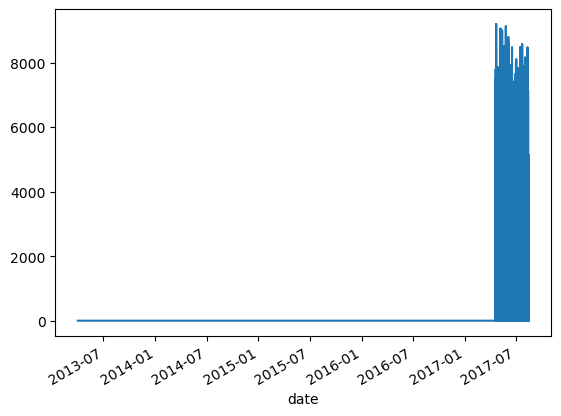

In [19]:
#sales for 52 store
data.loc[data.store_nbr == 52, 'sales_1'].plot()

In [20]:
#sksu with zero consumption before 2016 and nonzero in 2016
sku_3 = dg2.loc[(dg2.year == 2016) &\
            (dg2.sales_1 > 0) &\
                (dg2.cs == dg2.sales_1), 'sku'].unique()

In [21]:
len(sku_3)

43

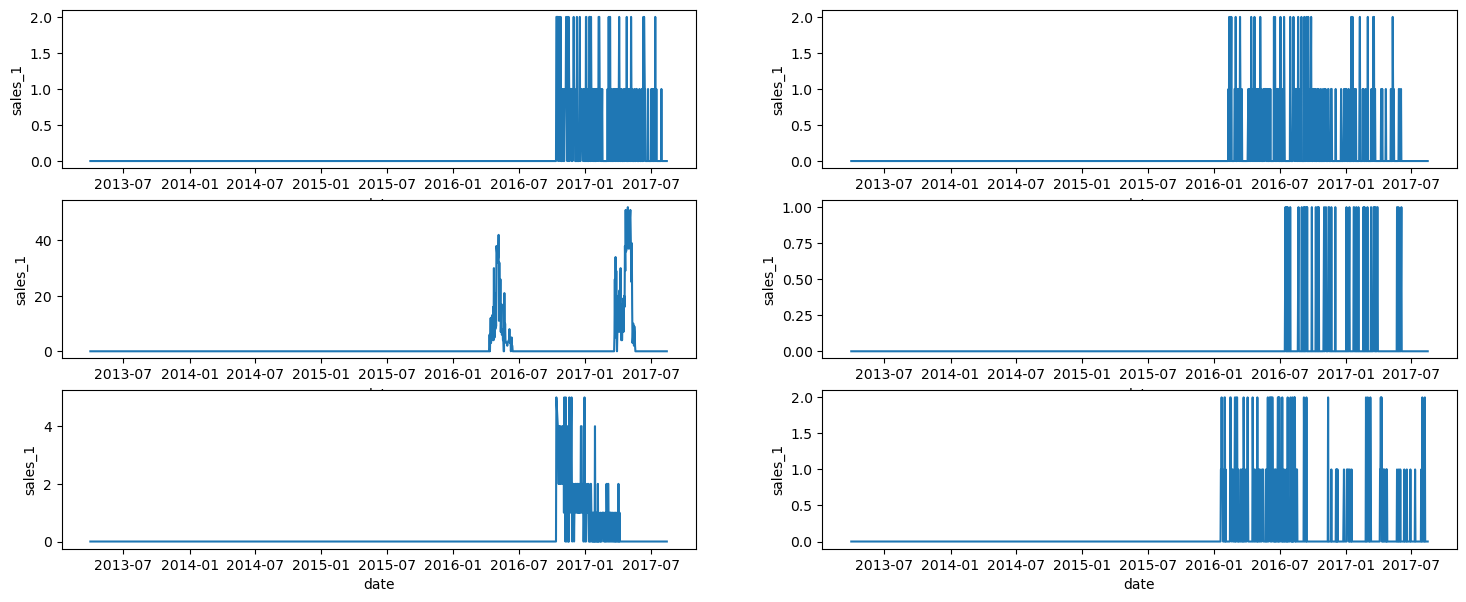

In [22]:
fig, axes = plt.subplots(3, 2, figsize = (18,7))
for n in range(6):
    sns.lineplot(data = data.loc[data.sku == sku_3[n], 'sales_1'], ax=axes[n//2][n%2])

##### `let's handle all such cases`

In [23]:
data = data.loc[~(data['cumsum'] == 0)]

In [24]:
y_cols = [x for x in data.columns if x.startswith('sales')]
x_cols = [x for x in data.columns if x not in y_cols]

In [25]:
#test split
test = data.loc[(data.index<holdout.index.min()) &\
                   (data.index >= '2017-06-01')]
train = data.loc[data.index < test.index.min()]

In [26]:
train.dropna(inplace=True)

### Feature analysis

In [30]:
train.loc[:, x_cols].columns

Index(['store_nbr', 'family', 'onpromotion', 'day', 'week', 'month', 'year',
       'trend', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'salary', 'outliers', 'y_lag_1', 'y_lag_2', 'y_lag_3',
       'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_30', 'MA_60', 'MA_90',
       'city', 'state', 'type', 'cluster', 'tr_10', 'tr_20', 'tr_30', 'oil_10',
       'oil_20', 'oil_30', 'national', 'local', 'regional', 'holiday', 'sku',
       'cumsum'],
      dtype='object')

In [31]:
base_features = ['store_nbr', 'family', 'onpromotion', 'day', 'week', 'month', 'year',
       'trend', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'salary', 'outliers', 'y_lag_1', 'y_lag_2', 'y_lag_3',
       'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_30', 'MA_60', 'MA_90',
       'city', 'state', 'type', 'cluster', 'tr_10', 'tr_20', 'tr_30', 'oil_10',
       'oil_20', 'oil_30', 'national', 'local', 'regional', 'holiday', 'sku']

In [32]:
# size_of_test = test_data.loc[test_data.month == parameters['test_months'][-1]].shape[0]

### MI score

In [33]:
from ts_tools import make_mi_scores, plot_mi_scores

In [34]:
X = train.loc['2017':, base_features].copy().reset_index(drop = True)
y = train.loc['2017':, 'sales_1'].copy().reset_index(drop = True)

# Label encoding for categoricals
for colname in X.select_dtypes(["object", "int64"]):
    X[colname], _ = X[colname].factorize()

In [35]:
discrete_features = np.where(X.dtypes == int)[0]

In [36]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

sku                  1.822751
MA_30                1.650927
MA_60                1.628625
MA_90                1.623224
MA_6                 1.613822
MA_5                 1.585560
MA_4                 1.561430
MA_3                 1.552446
MA_2                 1.534502
y_lag_1              1.486995
y_lag_2              1.362554
y_lag_3              1.315165
family               1.218798
onpromotion          0.537280
store_nbr            0.126859
cluster              0.088270
tr_20                0.070477
tr_30                0.067973
tr_10                0.064353
type                 0.057675
city                 0.054874
state                0.043896
cos(2,freq=A-DEC)    0.013559
trend                0.013509
cos(1,freq=A-DEC)    0.012533
oil_10               0.012003
oil_30               0.011822
sin(2,freq=A-DEC)    0.011523
week                 0.011292
oil_20               0.011167
sin(1,freq=A-DEC)    0.011151
day                  0.007735
sin(1,freq=M)        0.004243
s(1,7)    

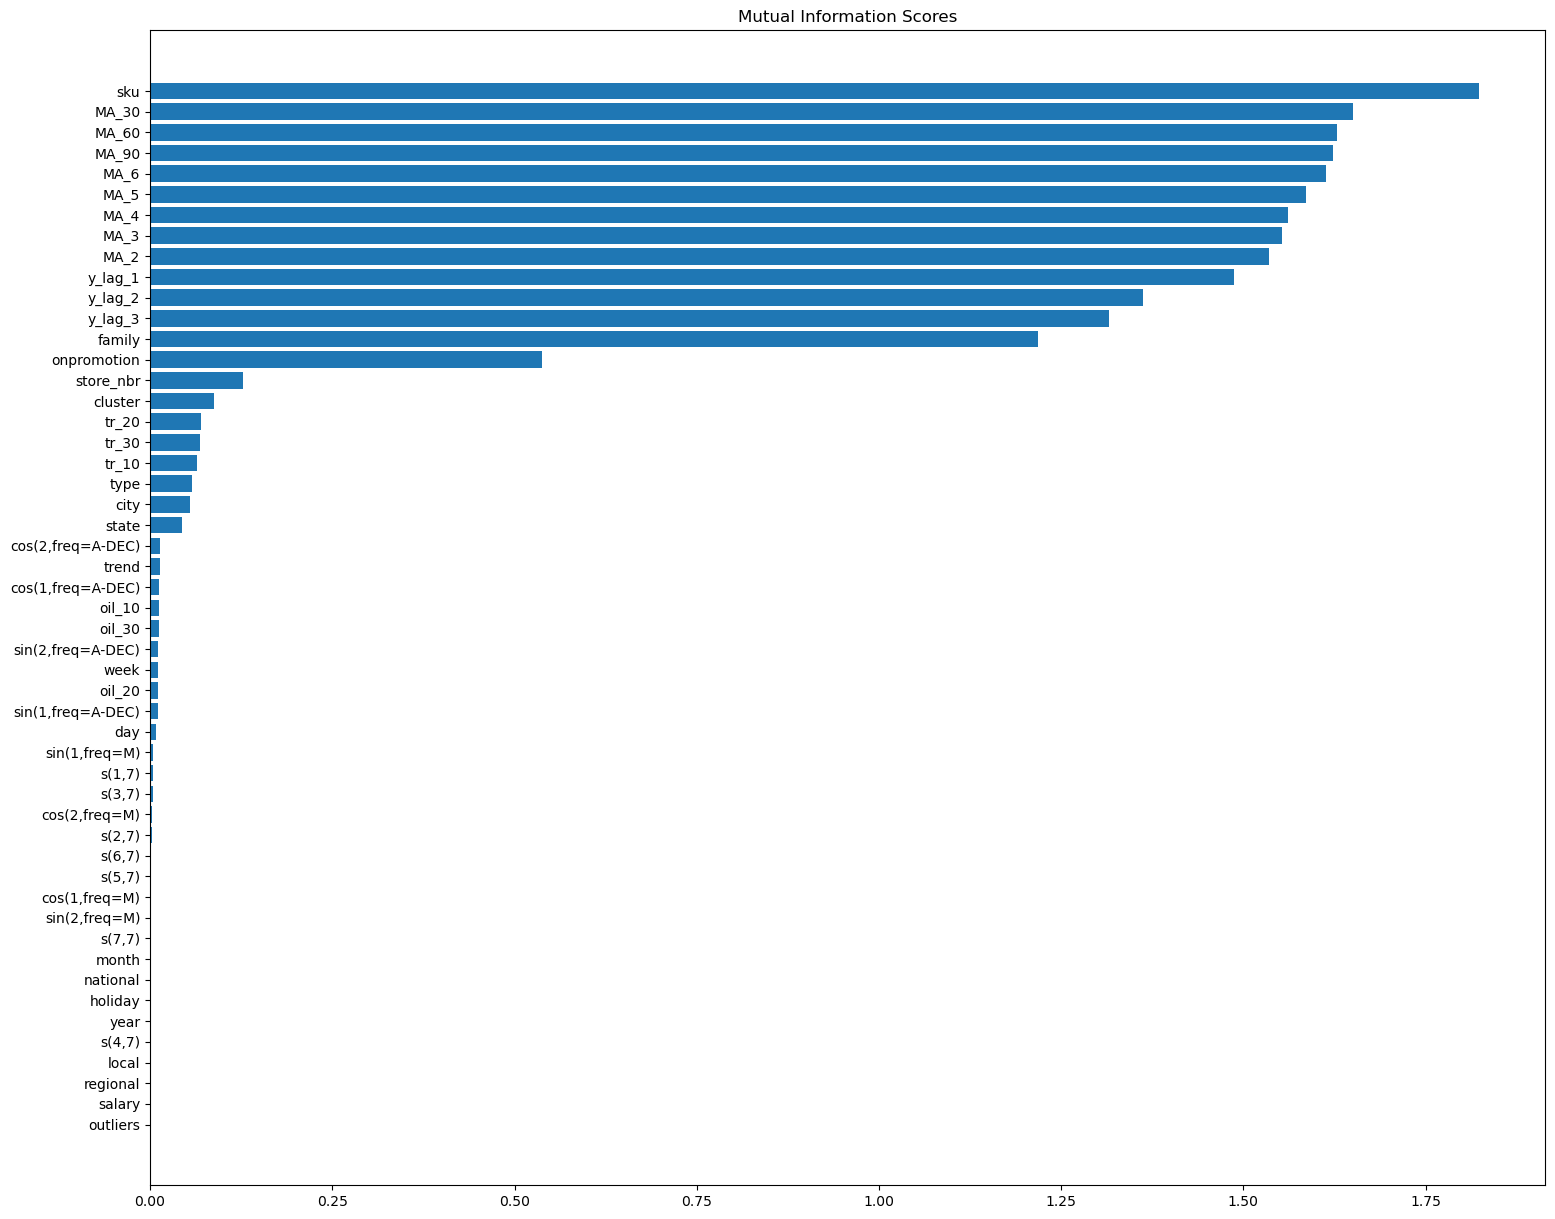

In [37]:
plt.figure(dpi=100, figsize=(18, 15))
plot_mi_scores(mi_scores)

### Pairplot

In [38]:
features_1 = ['onpromotion', 'MA_6', 'y_lag_3']

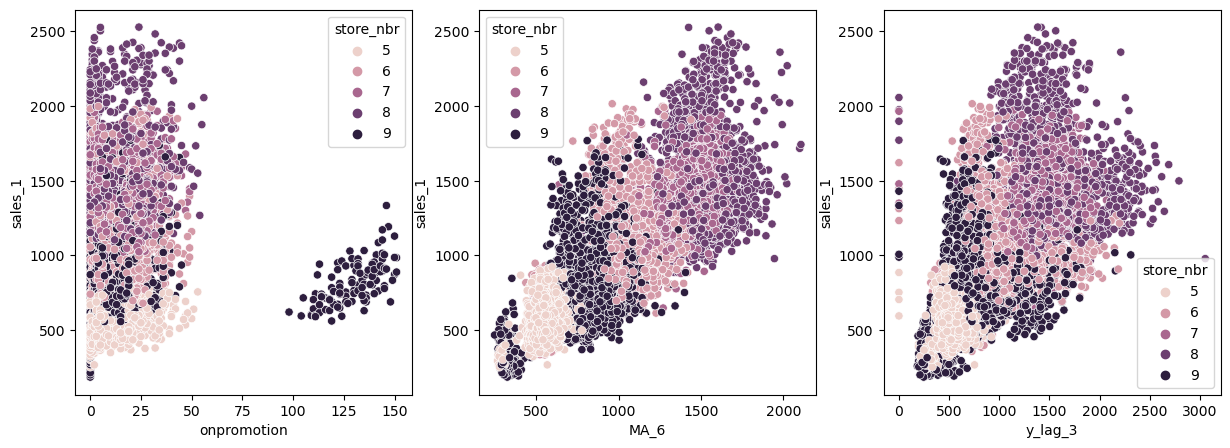

In [39]:
rows = int(len(features_1)//4+1*(len(features_1)%4 != 0))
plt.figure(figsize = (20,rows*5))
for n, _ in enumerate(features_1):
    ax = plt.subplot(rows, 4, n+1)
    sns.scatterplot(data = data.loc[(data.family == 'DAIRY') &\
                                       (data.store_nbr.isin(range(5,10)))], x = _, y = 'sales_1', ax = ax, hue = 'store_nbr')
    # try:
    #     # sns.kdeplot(data = train_data, x = _, ax = ax, shade = True)
    # except:
    #     continue
plt.show()

## Simplest approach

In [77]:
params = {
          'iterations': 1000,
          'l2_leaf_reg': 5.0,
          'task_type': 'CPU',
          'verbose': 200,
          'border_count': 32,
          'cat_features': discrete_features,
          'early_stopping_rounds': 200
    }

In [78]:
mask_holdout = holdout.sku.isin(sku_1)
mask_final = final.sku.isin(sku_1)

In [79]:
from tqdm.notebook import trange, tqdm

In [80]:
for seed in trange(len(y_cols)):
    cat = CatBoostRegressor(**params, random_state = seed+34)
    cat.fit(train.loc['2016':, x_cols], train.loc['2016':, y_cols[seed]],
           eval_set=(test.loc[test.loc[:, y_cols[seed]].notna(), x_cols],
                     test.loc[test.loc[:, y_cols[seed]].notna(), y_cols[seed]]),
            early_stopping_rounds=200,
            use_best_model=True)
    holdout[f'y_{seed+1}'] = 0
    holdout.loc[~mask_holdout, f'y_{seed+1}'] = cat.predict(holdout.loc[~mask_holdout, x_cols])
    holdout[f'y_{seed+1}'] = holdout[f'y_{seed+1}'].clip(0.0)
    
    final[f'y_{seed+1}'] = 0
    final.loc[~mask_final, f'y_{seed+1}'] = cat.predict(final.loc[~mask_final, x_cols])
    final[f'y_{seed+1}'] = final[f'y_{seed+1}'].clip(0.0)

  0%|          | 0/16 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1288.0315690	test: 1343.7244732	best: 1343.7244732 (0)	total: 303ms	remaining: 5m 2s
200:	learn: 285.9532780	test: 286.5322366	best: 286.5322366 (200)	total: 1m 13s	remaining: 4m 51s
400:	learn: 245.2318620	test: 250.0318248	best: 250.0318248 (400)	total: 2m 30s	remaining: 3m 45s
600:	learn: 225.7993575	test: 236.8998959	best: 236.8998959 (600)	total: 3m 52s	remaining: 2m 34s
800:	learn: 214.0945924	test: 228.9750131	best: 228.9750131 (800)	total: 5m 22s	remaining: 1m 20s
999:	learn: 204.5893123	test: 222.6820397	best: 222.6699840 (997)	total: 6m 52s	remaining: 0us

bestTest = 222.669984
bestIteration = 997

Shrink model to first 998 iterations.
0:	learn: 1327.7893526	test: 1377.2732350	best: 1377.2732350 (0)	total: 467ms	remaining: 7m 46s
200:	learn: 423.0859074	test: 346.6061616	best: 346.6012028 (199)	total: 1m 27s	remaining: 5m 49s
400:	learn: 388.2617449	test: 319.5095101	best: 319.5095101 (400)	total: 2m 50s	remaining: 4m 15s
600:	learn: 369.4771213	test: 310.5823683	be

In [81]:
results = pd.DataFrame(columns=range(1,17))
for n in range(len(y_cols)):
    mask2 = holdout.loc[:, y_cols[n]].notna()
    results.loc[1, n+1] = mean_absolute_error(
            holdout.loc[mask2, y_cols[n]],
            holdout.loc[mask2, f'y_{n+1}'])

In [82]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,69.344928,84.184847,92.99493,85.673473,81.623181,81.883035,84.19254,88.20551,95.062166,94.674675,93.650421,93.570236,90.751043,98.892145,91.548729,101.011228


#### Example for highrunners

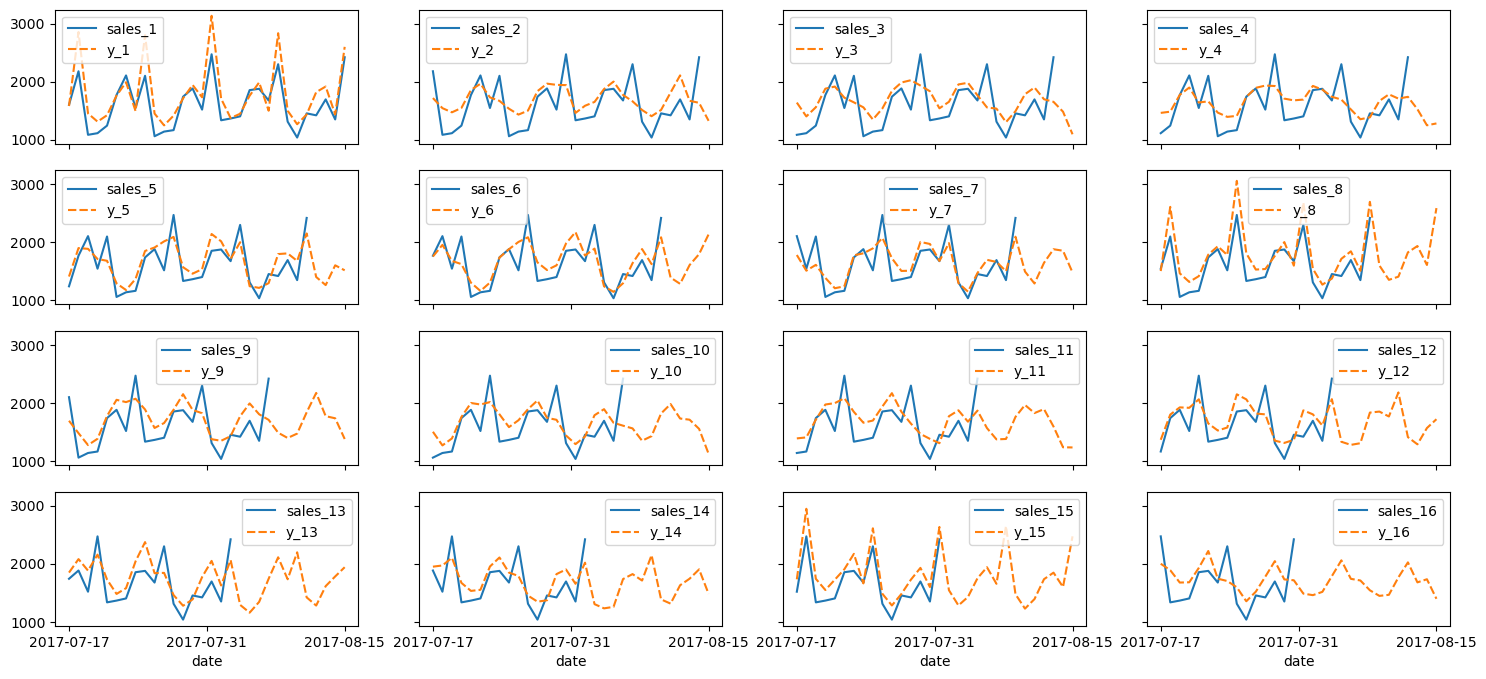

In [83]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 9) &\
             (holdout.family == 'PRODUCE'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

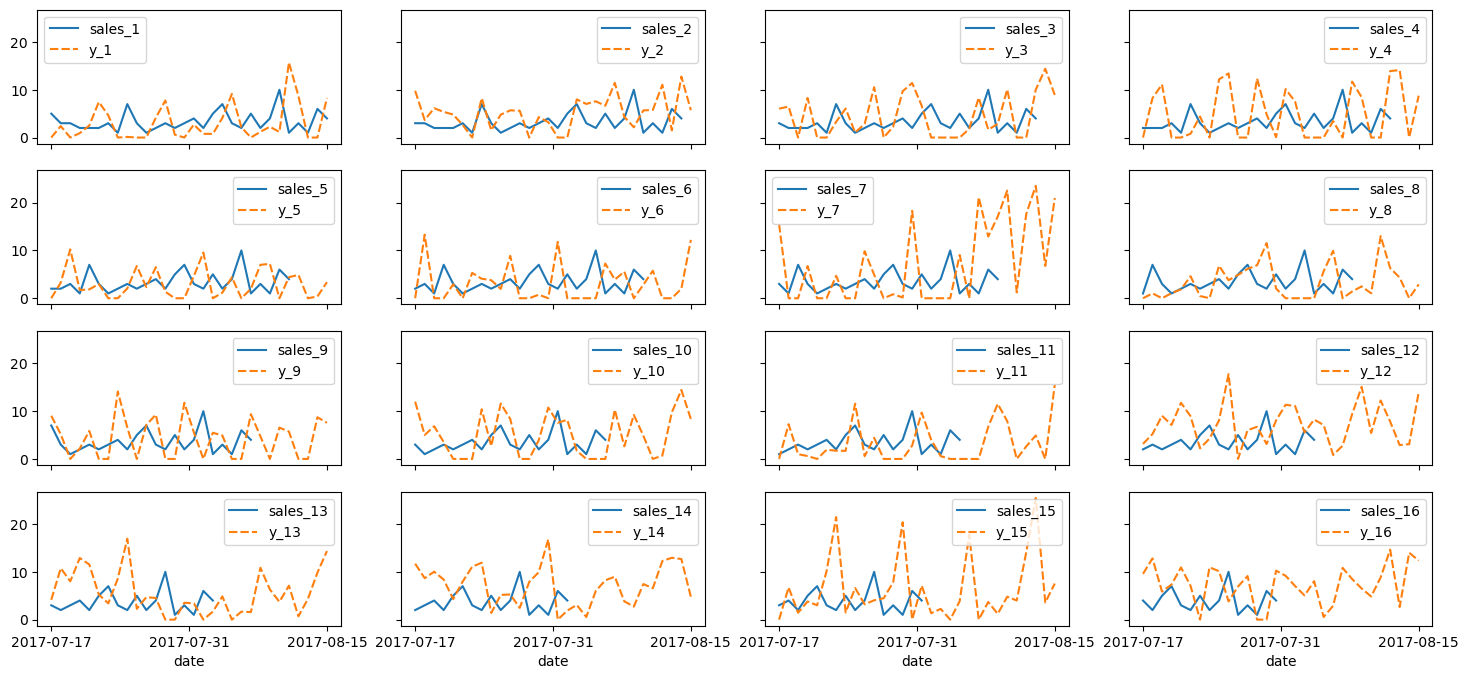

In [84]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 1) &\
             (holdout.family == 'BEAUTY'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

In [85]:
import shap

In [86]:
explainer = shap.TreeExplainer(cat)

In [87]:
shap_values = explainer.shap_values(train.loc[:, x_cols])

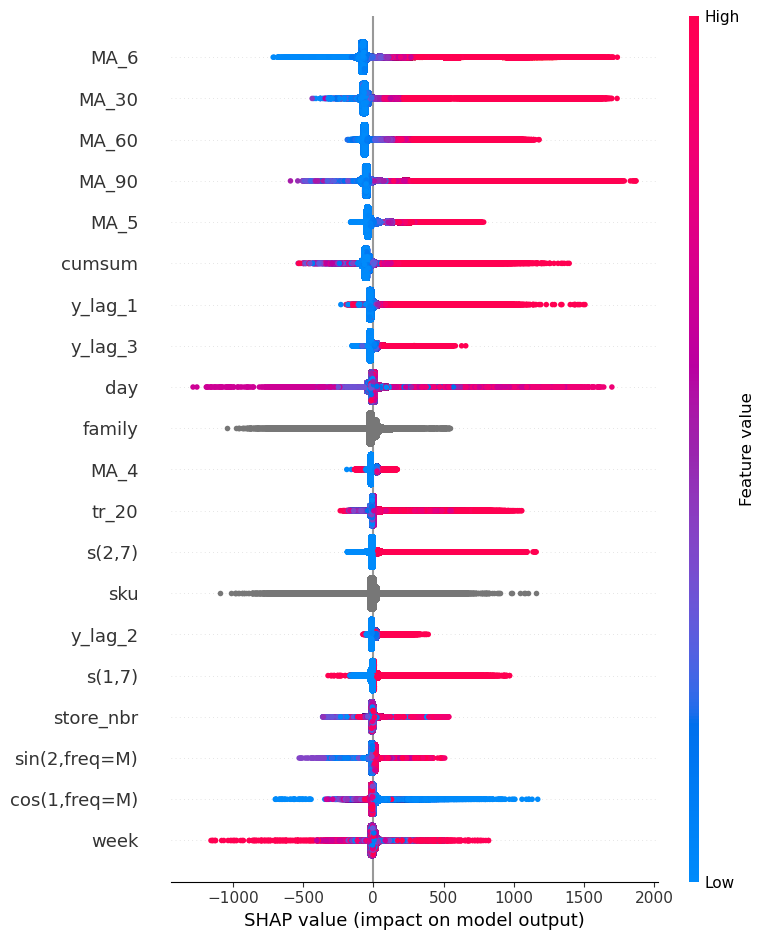

In [88]:
shap.summary_plot(shap_values, train.loc[:, x_cols])

In [89]:
shap_value = explainer.shap_values(test.loc[(test.store_nbr == 9) &\
             (test.family == 'PRODUCE'), x_cols])

In [90]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_value, x_cols)